In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse

## Build Index

In [2]:
# Something is messed up in this workflow where we end up with MUSG instead of MUST for the ensembl 
# Right now I am fixing this in the other notebook, so it should be okay in the end, but just a note if I work on this 
# in the future

In [2]:
#Check if the file was downloaded already before doing curl:
if not (os.path.isfile('Mus_musculus.GRCm38.cdna.all.fa.gz')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz
else: print('Mouse transcriptome already downloaded!')

Mouse transcriptome already downloaded!


In [3]:
### Now we can build the index
if not (os.path.isfile('mouse_transcriptome_index.idx')): 
    !kallisto index -i mouse_transcriptome_index.idx Mus_musculus.GRCm38.cdna.all.fa.gz
else: print ('Mouse transcript index already exist!')

Mouse transcript index already exist!


### Download human and mouse reference transcriptomes from ensembl
In order to do that we first download the human and mouse transcriptomes from ensembl. You can see the reference genomes they have at https://uswest.ensembl.org/info/data/ftp/index.html

In [4]:
#Check if the file was downloaded already before doing curl:
if not (os.path.isfile('Mus_musculus.GRCm38.94.gtf.gz')) or os.path.isfile('Mus_musculus.GRCm38.94.gtf'): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus/Mus_musculus.GRCm38.94.gtf.gz
else: print('Mouse GTF already downloaded!')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.0M  100 28.0M    0     0  10.1M      0  0:00:02  0:00:02 --:--:-- 10.1M


In [5]:
# Unzip the files
!gunzip -v -f ./Mus_musculus.GRCm38.94.gtf.gz

./Mus_musculus.GRCm38.94.gtf.gz:	 96.2% -- replaced with ./Mus_musculus.GRCm38.94.gtf


## Create transcript_to_gene.tsv
Now we can use the cells below to parse the GTF file and keep only the transcript mapping as a tsv file in the format below.

In [2]:
def create_transcript_list(input, use_name = True, use_version = True):
    r = {}
    for line in input:
        if len(line) == 0 or line[0] == '#':
            continue
        l = line.strip().split('\t')
        if l[2] == 'transcript':
            info = l[8]
            d = {}
            for x in info.split('; '):
                x = x.strip()
                p = x.find(' ')
                if p == -1:
                    continue
                k = x[:p]
                p = x.find('"',p)
                p2 = x.find('"',p+1)
                v = x[p+1:p2]
                d[k] = v


            if 'transcript_id' not in d or 'gene_id' not in d:
                continue

            tid = d['transcript_id']
            gid = d['gene_id']
            if use_version:
                if 'transcript_version' not in d or 'gene_version' not in d:
                    continue

                tid += '.' + d['transcript_version']
                gid += '.' + d['gene_version']
            gname = None
            if use_name:
                if 'gene_name' not in d:
                    continue
                gname = d['gene_name']

            if tid in r:
                continue

            r[tid] = (gid, gname)
    return r



def print_output(output, r, use_name = True):
    for tid in r:
        if use_name:
            output.write("%s\t%s\t%s\n"%(tid, r[tid][0], r[tid][1]))
        else:
            output.write("%s\t%s\n"%(tid, r[tid][0]))

In [7]:
with open('./Mus_musculus.GRCm38.94.gtf') as file:
    r = create_transcript_list(file, use_name = True, use_version = True)
with open('mouse_transcript_to_gene.tsv', "w+") as output:
    print_output(output, r, use_name = True)
print('Created mouse_transcript_to_gene.tsv file')

Created mouse_transcript_to_gene.tsv file


In [3]:
!kallisto bus -i mouse_transcriptome_index.idx  -o out_gmp_merged -x 10xv2 -t 2 \
200630Van/D20-2488-4537L/200630Van_D20-2488_1_sequence.fastq 200630Van/D20-2488-4537L/200630Van_D20-2488_2_sequence.fastq \
200630Van/D20-3269-4585G/200630Van_D20-3269_1_sequence.fastq 200630Van/D20-3269-4585G/200630Van_D20-3269_2_sequence.fastq



[index] k-mer length: 31
[index] number of targets: 115,270
[index] number of k-mers: 98,989,067
[index] number of equivalence classes: 419,171
[quant] will process sample 1: 200630Van/D20-2488-4537L/200630Van_D20-2488_1_sequence.fastq
                               200630Van/D20-2488-4537L/200630Van_D20-2488_2_sequence.fastq
[quant] will process sample 2: 200630Van/D20-3269-4585G/200630Van_D20-3269_1_sequence.fastq
                               200630Van/D20-3269-4585G/200630Van_D20-3269_2_sequence.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 856,330,008 reads, 596,570,566 reads pseudoaligned


In [4]:
#load transcript to gene file
tr2g = {}
trlist = []
with open('./mouse_transcript_to_gene.tsv') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./out_gmp_merged/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

### Processing the BUS file
For these notebooks we will work with the text file that BUStools produces, rather than the raw BUS file. To install BUStools see https://github.com/BUStools/bustools

We discard any barcodes that don't have more 10 UMIs

To produce the text file, starting with the output.bus file produced by kallisto, we first sort it on bustools:

bustools sort -o output.sorted output.bus
Then we convert it to txt:

bustools text -o output.sorted.txt output.sorted

In [5]:
#sort bus file
!bustools sort -o ./out_gmp_merged/output_sorted.bus ./out_gmp_merged/output.bus

Read in 596570566 number of busrecords


In [6]:
!bustools text -o ./out_gmp_merged/output_sorted.txt ./out_gmp_merged/output_sorted.bus

Read in 472774795 number of busrecords


## Loading generated data

In [7]:
#load transcripts
tr2g = {}
trlist = []
with open('./mouse_transcript_to_gene.tsv') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./out_gmp_merged/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

In [8]:
# load kallisto bus output dataset
cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./out_gmp_merged/output_sorted.txt') as f:
    gs = set()
    c = 0
    for line in f:
        if (c % 5000000) == 0:
            print(c)
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
        c += 1
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]

0
5000000
10000000
15000000
20000000
25000000
30000000
35000000
40000000
45000000
50000000
55000000
60000000
65000000
70000000
75000000
80000000
85000000
90000000
95000000
100000000
105000000
110000000
115000000
120000000
125000000
130000000
135000000
140000000
145000000
150000000
155000000
160000000
165000000
170000000
175000000
180000000
185000000
190000000
195000000
200000000
205000000
210000000
215000000
220000000
225000000
230000000
235000000
240000000
245000000
250000000
255000000
260000000
265000000
270000000
275000000
280000000
285000000
290000000
295000000
300000000
305000000
310000000
315000000
320000000
325000000
330000000
335000000
340000000
345000000
350000000
355000000
360000000
365000000
370000000
375000000
380000000
385000000
390000000
395000000
400000000
405000000
410000000
415000000
420000000
425000000
430000000
435000000
440000000
445000000
450000000
455000000
460000000
465000000
470000000


In [9]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s

385190


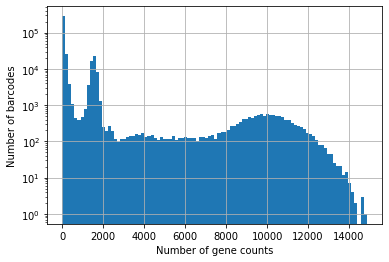

In [10]:
threshold = 0 # this filters the data by gene count
bcv = [x for b,x in barcode_hist.items() if x > 0] 
_ = plt.hist(bcv,bins=100, log=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.xlabel("Number of gene counts")
plt.ylabel("Number of barcodes")
plt.grid(True)
print(len(bcv))

## Export as .mtx

In [11]:
outfile = './out_gmp_merged/matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 500]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])

In [12]:
len(barcodes_to_use)

72017

In [13]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))

In [21]:
gene_names = {}
with open('./mouse_transcript_to_gene.tsv') as f:
    f.readline()
    for line in f:
        t,g,gn = line.split()
        gene_names[g] = gn

In [18]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if g in gene_names:
        gn = gene_names[g]
    else:
        gn = ''
    gl.append((g,gn))

with open('./out_gmp_merged/genes_t.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('./out_gmp_merged/barcodes.tsv','w') as of:
    of.write('\n'.join(x + '-1' for x in barcodes_to_use))
    of.write('\n')

In [22]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,10):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    print(g)
    if g in gene_names:
        gn = gene_names[g]
    else:
        gn = ''
    print(gn)
    gl.append((g,gn))

ENSMUSG00000080735.1

ENSMUSG00000109789.1

ENSMUSG00000048281.9

ENSMUSG00000099108.1

ENSMUSG00000022253.15

ENSMUSG00000097340.1

ENSMUSG00000110118.1

ENSMUSG00000058172.1

ENSMUSG00000035158.15

